In [31]:
import pandas as pd
import ipcalc
import parse_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import user_agents as ua
from helpers import filter_other, autopct_format
import calendar

# Vorbereitung: Einlesen der Daten
- Für die Analsyse müssen die Daten des acces.log Datei eingelesen werden!

### Schwierigkeit
- Größe des Datensatzes: 10.365.152 Log Einträge (über 10 Milionen)
- keine eindeutiges Trennzeichen in den Daten vorhanden
- kein von Pandas vorgefertigter Import für Log Dateien

**So sehen die Anfragen aus:**
```
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200 5667 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"

31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200 5379 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
```

### Lösung
- Nutzung des Read_CSV Befehls angewandt auf die acces.log-Datei
- Anwendung möglich durch die Angabe des Seperators mitthilfe einer Regular Expression ```sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)'```
- Nach eindeutiger zuordnung des Trennzeichens können Daten eingelesen werden!

**Nachteil:** Die Ladezeit ist aufgrund der Größe des Datensatzes relativ lang (ca. 10-15 Minuten)

In [ ]:
# Source: https://mmas.github.io/read-apache-access-log-pandas
access_log = pd.read_csv(
    'data/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': pf.parse_datetime,
                'request': pf.parse_str,
                'status': int,
                'size': int,
                'referer': pf.parse_str,
                'user_agent': pf.parse_str},
    on_bad_lines='warn')

access_log.head()


# Umwandlung in CSV Datei
- Nachdem Daten eingelesen wurden diese direkt als CSV-Datei "zwischenspeichern"

**Vorteil:** Verkürzt die Ladezeit auf ca. 3-4 Minuten
- CSV Datei kann genutzt werden um die Daten erneut einzulesen <br>
- Das Einladen über die strukturierte CSV Datei geht deutlich schneller als laden der Daten aus der acces.log Datei

In [ ]:
# Daten in einer CSV Datei speichern
filename = "data/acces_log.csv"
access_log.to_csv(filename)

# Daten aus CSV laden
- Die Daten aus der zuvor genrierten CSV Datei laden. 

**Wichtig:** Es muss zuvor die CSV Datei generiert werden, indem mindestens einmal die Daten aus der acces.log Datei eingelesen wurden!
- dieser Schritt wird also erst bei der mehrfachen Ausführung des Notebooks sinnvoll! 

In [3]:
# Daten aus CSV laden
filename = "data/acces_log.csv"
access_log_csv = pd.read_csv(filename)
print(len(access_log_csv))
access_log = access_log_csv

10365152


In [ ]:
# Erzeuge eine Kopie der Daten als "Backup" 
access_log_backup = access_log.copy()
len(access_log_backup)

## Daten konvertieren & normalisieren
Die in der CSV hinterlegten Daten in die benötigten Datentypen überführen

- time: soll als Datum im Pandas Dataframe hinterlegt und entsprechend Normalisiert werden!

In [28]:
# Typen konvertieren
access_log['time'] = pd.to_datetime(access_log['time'])

# Daten normalisieren
access_log['time'] = access_log['time'].dt.tz_convert('UTC')

# Aufgabe 1: Beliebtestes Produkt

> Analysieren Sie welche Produkte beliebt sind. Entwickeln Sie dazu eine Definition eines beliebten Produktes. Stellen Sie die Ergebnisse anschaulich da.

## Definition

> Das Produkt mit dein meisten Aufrufen auf dem Webserver

## Ergebnis

Product: Galaxy-J6-Plus-Dual-32GB | ProductID 33968


In [22]:
def extract_product_id(request):
  m = re.search(r"\s\/product\/(\d+)\/", str(request))
  if m:
    return m.group(1)
  return None

access_log['product_id'] = access_log['request'].map(extract_product_id)
access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id
0,0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None
1,1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
2,2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
3,3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None
4,4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893


764 x ID: 33953
23019       GET /product/33953/64709/%DA%AF%D9%88%D8%B4%DB...
38344       GET /product/33953/%DA%AF%D9%88%D8%B4%DB%8C-%D...
64386       GET /product/33953/64709/%DA%AF%D9%88%D8%B4%DB...
74693       GET /product/33953/64709/%DA%AF%D9%88%D8%B4%DB...
77080       GET /product/33953/64709/%DA%AF%D9%88%D8%B4%DB...
                                  ...                        
10239112    GET /product/33953/%DA%AF%D9%88%D8%B4%DB%8C-%D...
10288142    GET /product/33953/64708/%DA%AF%D9%88%D8%B4%DB...
10290926    GET /product/33953/%DA%AF%D9%88%D8%B4%DB%8C-%D...
10304668    GET /product/33953/65412/%DA%AF%D9%88%D8%B4%DB...
10341838    GET /product/33953/65410/%DA%AF%D9%88%D8%B4%DB...
Name: request, Length: 764, dtype: object


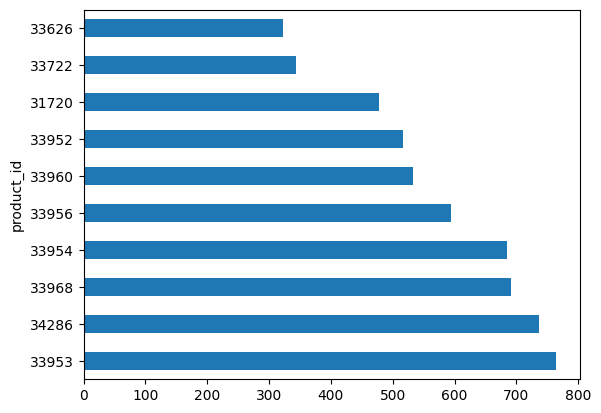

In [26]:
most_viewed_products = access_log.loc[access_log['product_id'] != None].value_counts(access_log['product_id'])
most_viewed_products = most_viewed_products[0:10]
most_viewed_products.plot(kind='barh')
most_viewed_product_id = most_viewed_products.keys()[0]
print(most_viewed_products[0], 'x', 'ID:', most_viewed_product_id)

# TODO: Display Product for Id

# Aufgabe 2

> Untersuchen Sie den Datensatz auf weitere Auffälligkeiten.


## Basisinformationen durch Pandas-Befehle
- Pandas bietet bereits vordefinierte Befehle um einfache Informationen über die Daten zu ermitteln
- Mit den Befehlen zu beginnen, hilft dabei die Daten ein erstes mal zu erkunden!
- Speziell bei numerrischen Daten erhält man bereits eine Reihe an spannenden statistischen Informationen
- Auch für Daten wie die des Logs, lohnt es sich kurz beide Befehle anzugucken!

### Befehl `.info()`
- Übersicht über die Spalten
- Angabe zu den Datentypen der Spalten

In [ ]:
access_log.info()

### Befehl `.describe()`
- Anzahl der Einträge
- wie viele einzigartige Einträge
- höchste Zahl
- Durchschintt
- weitere statistische Angaben!

--> Statistische Basisinformationen <br>
--> Parameter `include = 'all'` notwendig, dass auch nicht numerische Daten in die Übersicht mit übernommen werden



In [ ]:
access_log.describe(include = 'all')

# Daten Anzeigen
- Zum Anzeigen der Daten können unterschiedliche Methoden genutzt werden
- Anzeigen durch Methoden: ``` .head(x) | .tail(x) ``` gibt die ersten / letzten x Zeilen aus
- indizierter Zugriff wie aus Python bekannt ```acces_log[10000:10200]```

In [ ]:
access_log.head(5)

In [ ]:
access_log[10000:10200]

## Grundlage Zugriff auf Attribute

- Aufruf möglich durch `acces_log.ip` oder `auch acces_log['ip']`

In [ ]:
# IP-Adressen mit den meisten Aufrufen 
access_log.value_counts('ip')

# Datenergänzung / Datenaufbereitung zur Analyse

### Timestamps

- Zur Analyse des Timestamps werden einzelne Spalten für Tag, Stunde (ToDo: Minute? Uhrzeit allgemein) erstellt
- Die neu erstellten Features können für Untersuchungen wir Aufrufe nach Tageszeit verwendet werden

In [34]:
access_log['date'] = access_log['time'].dt.date
access_log['weekday_n'] = access_log['time'].dt.weekday
access_log['weekday'] = access_log['weekday_n'].map(lambda wd: calendar.day_name[wd])
access_log['hour'] = access_log['time'].dt.hour

access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id,day,weekday,hour,date,weekday_n
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None,2019-01-22,Tuesday,0,2019-01-22,1
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,Tuesday,0,2019-01-22,1
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,Tuesday,0,2019-01-22,1
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None,2019-01-22,Tuesday,0,2019-01-22,1
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893,2019-01-22,Tuesday,0,2019-01-22,1


# Einfache Analyse der Anzahl einzelner Features:
- Zählen der Features durch ```.value_counts("feature")``` <br>
--> ermitteln welche IP Adresse die meisten Anfragen stellt <br>
--> Welches Produkt wurde am meisten angefragt 

In [30]:
# IP-Adressen mit den meisten Aufrufen 
access_log.value_counts("ip")

ip
66.249.66.194      353483
66.249.66.91       314522
151.239.241.163     92475
66.249.66.92        88332
91.99.30.32         45979
                    ...  
5.217.114.109           1
2.185.112.228           1
37.44.58.168            1
5.119.191.23            1
5.52.183.148            1
Name: count, Length: 258606, dtype: int64

# Analyse der herausgearbeiteten Timestamp Eigenschaften 
- Analyse von Tag
- Analyse von Stunden

In [ ]:
# Analyse der Tage (Zugriffstage)
days_count = access_log.value_counts('day')
print(days_count)
days_count.sort_index().plot(kind='bar')

# Ausertung Tagesanzahl
- Die Log-Datei enthält Informationen zu 5 Tagen
- Die ersten beiden Tage haben eine leicht höhere Anzahl an Anfragen, ansonsten aber eine relativ gleiche Verteilung der Last über alle Tage

In [ ]:
# Analyse der Stunden (Zugriffszeiten)
hours_count = access_log.value_counts('hour')
print(hours_count)
hours_count.sort_index().plot(kind='bar')

# Auswertung Stundenanalyse (Zugriffszeiten)
- Klares Tief in der Nacht zu erkennen
- Morgens ab 5 Uhr steigt die Anzahl an Aufrufen rapide
- Peak ist um 8 Uhr Morgens
- Über den Nachmittag zum Abend hin sinken die Aufrufe wieder deutlich

In [ ]:
# ToDo: irgendwie verwerten? Time of the Day ist schön, aber bringt eigentlich nichts!
access_log.value_counts('time_of_day')

In [ ]:
# ToDo: Entfernen, Minute bringt auch nichts (oder fällt uns was spanneds zur Verwendung noch ein?)
access_log.value_counts('minute')

## Heatmap Tageszeit
- Alternative visualisierung der Tageszeiten
- ToDo: Beide Darstellung nutzen? Ich finde beide können noch gewinnbringend angewandt werden

In [ ]:
# Wochentag und Tageszeit einlesen
# access_log['weekday'] = access_log['time'].dt.weekday --> würde ich Am Start (Datenaufbereitung) einmal zusammen machen (und wird hier garnicht genutzt!)
access_log['daytime'] = access_log['time'].dt.hour

daytime_access = access_log.groupby(['daytime']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(columns='daytime', values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 1)

heatmap.set_title('Aufrufe nach Tageszeit')
heatmap.set_xlabel('Uhrzeit')


In [ ]:
# ToDo: GGF. Hier anstelle von 1-5 die Wochentage nutzen -> habe eine Spalte für Wochentage in der Tabelle erstellt (Einheitliches verwenden (0 / 1))

# Wochentag und Tageszeit einlesen
access_log['weekday'] = access_log['time'].dt.weekday
access_log['daytime'] = access_log['time'].dt.hour

daytime_access = access_log.groupby(['weekday', 'daytime']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(index='weekday',columns='daytime',values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 6)
# ax.set_yticks(range(0, 7), ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])

heatmap.set_title('Aufrufe nach Tag/Uhrzeit')
heatmap.set_xlabel('Uhrzeit')
heatmap.set_ylabel('Wochentag')

# 1 => Dienstag


## Request Methods
Herausarbeiten welche unterschiedlichen Requests an den Server gestellt wurden

Die folgenden Request Methoden gibt es:  
`GET`, `HEAD`, `POST`, `PUT`, `DELETE`, `CONNECT`, `OPTIONS`, `TRACE` und `PATCH`

Hierzu wird auf alle `Method` Einträge eine von uns definierte Extraktionsmethode `extract_method()` ausgeführt <br>
--> Wähle Strings die mit Großbuchstaben beginnen und alle zugehörigen Großbuchstaben. ToDo: prüfen!

In [ ]:
def extract_method(request):
  "Method to extract the HTTP-Method for a Request"
  m = re.match(r'^[A-Z]+', str(request))
  if m:
    return m.group()
  return None

access_log['method'] = access_log['request'].map(extract_method)
access_log.head()

In [ ]:
method_counts = access_log.loc[access_log['method'] != None]['method'].value_counts()
# Ausgabe aller Requests die gefunden werden konnten | ToDo: Absprechen: finde ich aber cooler als Other
print(method_counts)

# Zusammenfassen der Requests zur Veranschaulichung
method_counts_other = filter_other(method_counts, 0.005)
method_counts_other.plot(kind='pie', title='Request Methods', ylabel='Method', autopct=autopct_format(method_counts_other))

In [ ]:
# ToDo: prüfen / absprechen --> ggf. auch noch Grafik in der die Get Requests raus sind -> zeigt anderes Besser
method_counts_without_get = method_counts.drop(labels = 'GET')
method_counts_without_get.plot(kind='bar', title='Request Methods', ylabel='Method', autopct=autopct_format(method_counts_without_get))

In [ ]:
# ToDo: Entfernen -> wird Unnötig wenn wir alle ausgeben
method_counts.sort_values(ascending=False).head()

# Auswertung Request Methoden

- Sehr hohe Anzahl von Get Requests 98.3%
- Es existieren aber auch andere Reqeust
- 1.3% Post Requests
- Weitere Requests: HEAD; OPTIONS; CONNECT; G; E; PROPFIND

**ToDo:** Herausfinden was diese Reqeusts tun?

In [ ]:
access_log.loc[access_log['method'] == 'POST'].head()

## User Agents, Browser & OS

In [ ]:
agents = access_log['user_agent'].map(lambda agent: ua.parse(str(agent)))
access_log['browser_family'] = agents.map(lambda agent: agent.browser.family)
access_log['os_family'] = agents.map(lambda agent: agent.os.family)
access_log['device_family'] = agents.map(lambda agent: agent.device.family)
access_log['device_brand'] = agents.map(lambda agent: agent.device.brand)
access_log['device_model'] = agents.map(lambda agent: agent.device.model)
access_log['is_mobile'] = agents.map(lambda agent: agent.is_mobile)
access_log['is_pc'] = agents.map(lambda agent: agent.is_pc)
access_log['is_bot'] = agents.map(lambda agent: agent.is_bot)

access_log.head()

In [ ]:
browser_family_counts = access_log['browser_family'].value_counts()

browser_family_counts = filter_other(browser_family_counts)

browser_family_counts.plot(kind='pie', title='Browsers', ylabel='Browser', autopct=autopct_format(browser_family_counts))

In [ ]:
os_family_counts = access_log['os_family'].value_counts()

os_family_counts = filter_other(os_family_counts)

os_family_counts.plot(kind='pie', title='OS', ylabel='OS', autopct=autopct_format(os_family_counts))

In [ ]:
bot_counts = access_log['is_bot'].value_counts()

bot_counts.plot(kind='pie', title='Bots', ylabel='Bots', autopct=autopct_format(bot_counts))

### Reevaluation von Aufgabe 1

Ändert sich das Ergebnis, wenn wir Bots ausschließen?

In [ ]:
# Ergebnis von vorher
print('Ergebnis von vorher')
print(most_viewed_products[0], most_viewed_products.keys()[0])

print()

# Neues Ergebnis
print('Neues Ergebnis')
most_viewed_products2 = access_log.loc[access_log['is_bot'] != True].loc[access_log['request'].str.contains(r'^GET /product/\d+', na=False)].value_counts(access_log['request'])
print(most_viewed_products2[0], most_viewed_products2.keys()[0])

print()

# Evaluate
if most_viewed_products.keys()[0] == most_viewed_products2.keys()[0]:
    print('Gleiches Ergebnis')
else:
    print('Ergebnis verändert')
print('Differenz:', most_viewed_products[0] - most_viewed_products2[0], 'Bot-Aufrufe')

## Fehler

In [ ]:
status_counts = access_log['status'].value_counts()

status_counts = filter_other(status_counts, 0.01)

status_counts.plot(kind='pie', title='Status', ylabel='Status Code', autopct=autopct_format(status_counts))

In [ ]:
error_counts = access_log['status'].map(lambda status: status >= 400).value_counts()

error_counts.plot(kind='pie', title='Failed requests', ylabel='Error?', autopct=autopct_format(error_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] >= 400]

error_code_counts = error_logs['status'].value_counts()

error_code_counts = filter_other(error_code_counts, 0.01)

error_code_counts.plot(kind='pie', title='Error', ylabel='Error Code', autopct=autopct_format(error_code_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] != 200]
error_logs.head()

# Korrelationsanalyser der Daten

- Für Die Korrelationsanalyse sollten die weiiteren Daten noch in Numerische umgewandelt werden!
- Aktuell liegen kaum Numerische Daten vor!
- Daher werden zur Analyse einige Feature in Numerische Werte umgewandelt

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

In [ ]:
# Austesten (Dummies um Feature auf Numerisches Feature zu mappen!)
methods_numeric = pd.get_dummies(access_log['method'])
methods_numeric

In [ ]:
# Nur Get, Post, Head in die Korrelation mit nehmen -> rest löschen
# TODO: Sollte nur GET, POST, HEAD einschließen und nicht bestimmte ausschließen!
methods_numeric = methods_numeric.drop(['CONNECT','E','G','OPTIONS','PROPFIND'], axis=1)

access_log = access_log.join(methods_numeric)
access_log.head()

In [ ]:
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

## Open Ideas

- [x] Nutzung im Tagesverlauf (UTC) (Flo)
  * Wochentage analysieren
- [ ] IP auf Locations mappen
- [ ] Nutzung nach Tageszeit (korrigiert nach Location / Timezone based on IP)
- [x] Requests außer `GET`? (Flo)
- [x] Aufrufe mit Status `!= 200` => Fehler
- [ ] Referers analysieren
- [ ] Nach Nutzer und Pfaden gruppieren und zählen => Entscheidungsfreudigkeit der Nutzer
- [ ] Korrelation untersuchen
- [ ] Sessions von Nutzern zählen / schätzen
- [x] Browser analysieren (Flo)